In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio

import folium
import folium.plugins
from folium.plugins import MarkerCluster



from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy
%matplotlib inline  

Using TensorFlow backend.


In [76]:
crime = pd.read_csv('/Users/jenniferwu/Desktop/MSBA/Fall 2019/Data Analytics/crimes-in-boston/crimetodate.csv'
                    ,encoding = 'latin')
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435655 entries, 0 to 435654
Data columns (total 17 columns):
INCIDENT_NUMBER        435655 non-null object
OFFENSE_CODE           435655 non-null int64
OFFENSE_CODE_GROUP     426840 non-null object
OFFENSE_DESCRIPTION    435655 non-null object
DISTRICT               433439 non-null object
REPORTING_AREA         435655 non-null object
SHOOTING               10562 non-null object
OCCURRED_ON_DATE       435655 non-null object
YEAR                   435655 non-null int64
MONTH                  435655 non-null int64
DAY_OF_WEEK            435655 non-null object
HOUR                   435655 non-null int64
UCR_PART               426730 non-null object
STREET                 422330 non-null object
Lat                    399636 non-null float64
Long                   399636 non-null float64
Location               435655 non-null object
dtypes: float64(2), int64(4), object(11)
memory usage: 56.5+ MB


In [77]:
crime['Location_lat']= [i.split(', ')[0].split('(')[1] for i in crime.Location]
crime['Location_long']= [i.split(', ')[1].split(')')[0] for i in crime.Location]

crime['Location_lat']=crime.Location_lat.astype('float64')
crime['Location_long']=crime.Location_long.astype('float64')

In [78]:
crime.drop('Location', axis = 1, inplace = True)

In [79]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435655 entries, 0 to 435654
Data columns (total 18 columns):
INCIDENT_NUMBER        435655 non-null object
OFFENSE_CODE           435655 non-null int64
OFFENSE_CODE_GROUP     426840 non-null object
OFFENSE_DESCRIPTION    435655 non-null object
DISTRICT               433439 non-null object
REPORTING_AREA         435655 non-null object
SHOOTING               10562 non-null object
OCCURRED_ON_DATE       435655 non-null object
YEAR                   435655 non-null int64
MONTH                  435655 non-null int64
DAY_OF_WEEK            435655 non-null object
HOUR                   435655 non-null int64
UCR_PART               426730 non-null object
STREET                 422330 non-null object
Lat                    399636 non-null float64
Long                   399636 non-null float64
Location_lat           435655 non-null float64
Location_long          435655 non-null float64
dtypes: float64(4), int64(4), object(10)
memory usage: 59.8+ M

In [80]:
#changing the datatype to date time and creating a separate column just for the date occured

crime['date_occured']=[i.split(' ')[0] for i in crime.OCCURRED_ON_DATE]
crime['occured_on_dttm'] = pd.to_datetime(crime.OCCURRED_ON_DATE)

In [81]:
#dropping the original date column
crime.drop(columns = 'OCCURRED_ON_DATE', inplace = True)

In [82]:
#replace Values in Shooting variable into 0,1
crime['SHOOTING'] = crime['SHOOTING'].replace(to_replace = np.nan, value =0) 
crime['SHOOTING'] = crime['SHOOTING'].replace(to_replace = 'Y', value=1)

Removing Null Lat & Long for Final Cleaned Data used for EDA

In [83]:
crime = crime[(crime.Lat.notnull()) & (crime.Location_lat != 0) | (crime.Long.notnull()) & (crime.Location_long != 0)]
#crime.to_csv('/Users/jenniferwu/Desktop/MSBA/Fall 2019/Data Analytics/crimes-in-boston/crimetodate_cleaneddata.csv')

Assigning Crime Score based on : https://courses.lumenlearning.com/suny-criminallaw/chapter/1-4-classification-of-crimes/

https://study.com/academy/lesson/general-categories-of-crime.html

1.Felonies (Serious Crime)
2.Misdemeanors (Less Serious Crime)
3.Infractions (or Violation, minor crime)

min data date : 2015-06-15 00:00:00
max data date : 2019-10-13 09:28:24
Incomplete year data on 2015 & 2019


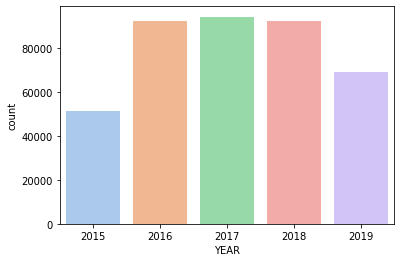

In [84]:
sns.countplot("YEAR", data = crime)
print("min data date :", min(crime.occured_on_dttm))
print("max data date :", max(crime.occured_on_dttm))
print("Incomplete year data on 2015 & 2019")

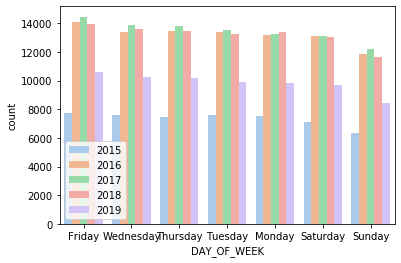

In [85]:
#plotting Crime Distribution by Day of Week and Comparing the years
#result = Pretty Flat :(
sns.set_palette("pastel")
sns.countplot("DAY_OF_WEEK",order=crime.DAY_OF_WEEK.value_counts().index,hue = "YEAR",data = crime)
plt.legend(loc='lower left')

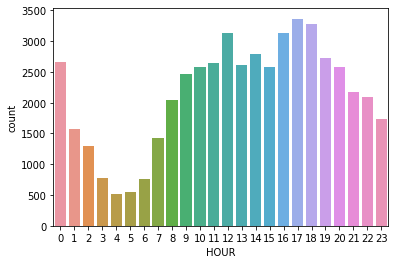

In [86]:
#plotting Crime Distribution by hour
#result = starts from 7AM & Peaks in the Afternoon (4pm to 7pm) -- this is true across all 4 years

#2k15
sns.countplot("HOUR", data = crime[crime.YEAR == 2015])

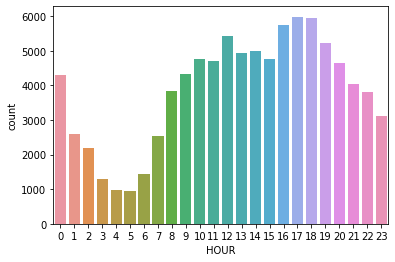

In [87]:
#2k16
sns.countplot("HOUR",data = crime[crime.YEAR == 2016])

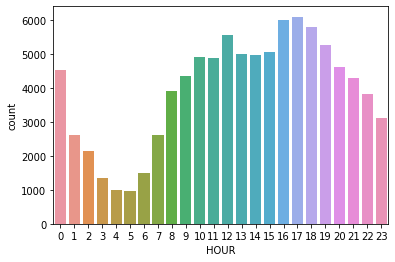

In [88]:
#2k17
sns.countplot("HOUR",data = crime[crime.YEAR == 2017])

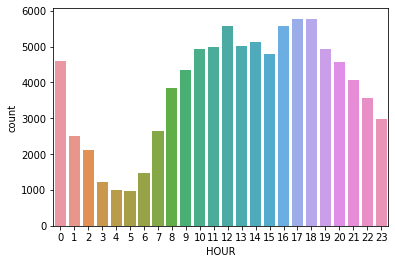

In [89]:
#2k18
sns.countplot("HOUR",data = crime[crime.YEAR == 2018])

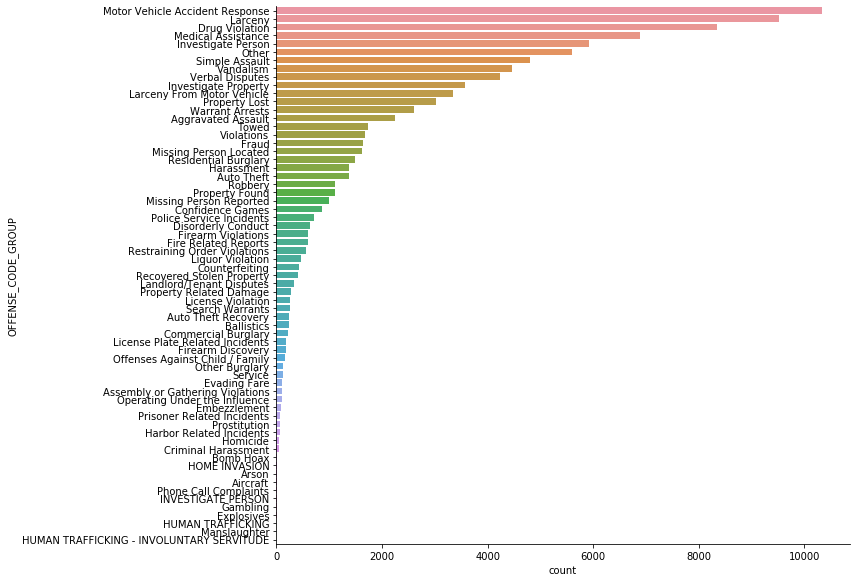

In [90]:
##Offense Group During Peak Time (4pm to 7 pm, 11pm to 12am)
hr = crime[(crime.HOUR >= 16) & (crime.HOUR <=19) | (crime.HOUR >= 23) &(crime.HOUR <=0)]

sns.catplot(y='OFFENSE_CODE_GROUP',
           kind='count',
            height=8, 
            aspect=1.5,
            order=hr.OFFENSE_CODE_GROUP.value_counts().index,
           data=hr)

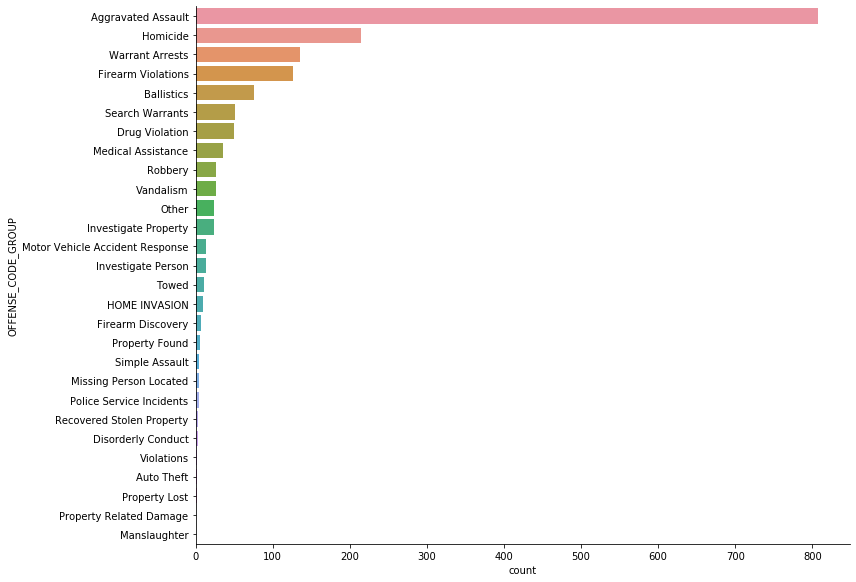

In [91]:
#type of offense code where there is shootings
shtgs = crime[crime.SHOOTING == 1]


sns.catplot(y='OFFENSE_CODE_GROUP',
           kind='count',
            height=8, 
            aspect=1.5,
            order=shtgs.OFFENSE_CODE_GROUP.value_counts().index,
           data=shtgs)

In [92]:
#Finding areas where there is more than 5 crime incidents
tmp = crime.groupby('INCIDENT_NUMBER')['YEAR'].count().sort_values(ascending = False)
tmp = pd.DataFrame({'INCIDENT_NUMBER': tmp.index, 'NUM_RECORDS': tmp.values})
seriousCrimes = crime.merge(tmp[tmp['NUM_RECORDS'] > 5], on = 'INCIDENT_NUMBER', how = 'inner')
seriousCrimes = seriousCrimes[['INCIDENT_NUMBER', 'Lat','Long']].drop_duplicates()[['Lat','Long']].dropna()

In [93]:
# Used this tutorial: https://medium.com/@bobhaffner/folium-markerclusters-and-fastmarkerclusters-1e03b01cb7b1
boston = folium.Map(location = [seriousCrimes['Lat'].mean(), 
                                  seriousCrimes['Long'].mean()], 
                      zoom_start = 12)
mc = MarkerCluster()
#creating a Marker for each point. 
for row in seriousCrimes.itertuples():
    mc.add_child(folium.Marker(location = [row.Lat,  row.Long]))

boston.add_child(mc)

boston

In [94]:
###shooting data
shtng = crime[(crime.SHOOTING == 1) & (crime.DISTRICT.notnull())]

boston1 = folium.Map(location = [shtng['Lat'].mean(), 
                                  shtng['Long'].mean()], 
                      zoom_start = 12)
mc = MarkerCluster()
#creating a Marker for each point. 
for row in shtng.itertuples():
    mc.add_child(folium.Marker(location = [row.Lat,  row.Long]))

boston1.add_child(mc)

boston1

## Model Creation

In [95]:
#######Creating Train & Test Dataset for Model

msk = np.random.rand(len(crime)) < 0.8
train = pd.DataFrame(crime[msk])
test = pd.DataFrame(crime[~msk])

Testing the split of Test & Train

In [96]:
print(train.shape)
print(test.shape)

(319694, 19)
(79942, 19)


In [119]:
def parse_time(x):
    DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    return time,day,month,year

def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

In [122]:
crime.OFFENSE_DESCRIPTION.value_counts()

SICK/INJURED/MEDICAL - PERSON                   25139
INVESTIGATE PERSON                              23820
M/V - LEAVING SCENE - PROPERTY DAMAGE           19368
VANDALISM                                       19088
ASSAULT SIMPLE - BATTERY                        18745
                                                ...  
FRAUDS - ALL OTHER                                  1
A&B HANDS, FEET, ETC.  - MED. ATTENTION REQ.        1
B&E NON-RESIDENCE NIGHT - FORCE                     1
AUTO THEFT - OUTSIDE - RECOVERED IN BOSTON          1
PRISONER ATTEMPT TO RESCUE                          1
Name: OFFENSE_DESCRIPTION, Length: 239, dtype: int64